# SVM

***

## Importando bibliotecas

In [52]:
# Bibliotecas de manipualção e visualização de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

# Classes do modelo
from sklearn.svm import SVC

# Funções de avaliação dos modelos
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

## Métodos para visualização

In [53]:
# Extraído de https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(
        X, 
        Y, 
        P, 
        colors='k',
        levels=[-1, 0, 1], 
        alpha=0.5,
        linestyles=['--', '-', '--']
    )
    
    # plot support vectors
    if plot_support:
        ax.scatter(
            model.support_vectors_[:, 0],
            model.support_vectors_[:, 1],
            s=300, 
            linewidth=1, 
            facecolors='none'
        )

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [54]:
def show_decision_region(X, y, model):
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    
    feature_0 = X.columns[0]
    feature_1 = X.columns[1]

    plot_decision_regions(np.array([X[feature_0].values,
                                    X[feature_1].values]).T,
                                    y.values.flatten(), model)
    plt.xlabel(feature_0)
    plt.ylabel(feature_1)

    plt.title(model.__class__.__name__)
    plt.show()

In [55]:
def plot_dataset(X, y, ax=None):
    X = np.array(X)
    y = np.array(y)
    
    # cores e simbolos para as classses
    colors = {0: "steelblue", 1: "darkorange", 2: "mediumseagreen"}
    markers = {0: "s", 1: "^", 2:"o"}

    if ax is None:
        plt.scatter(X[y==0, 0],X[y==0, 1], c=colors[0], marker=markers[0])
        plt.scatter(X[y==1, 0],  X[y==1, 1], c=colors[1], marker=markers[1])
    else:
        ax.scatter(X[y==0, 0],X[y==0, 1], c=colors[0], marker=markers[0])
        ax.scatter(X[y==1, 0],  X[y==1, 1], c=colors[1], marker=markers[1])
    

## conjunto de dados

In [56]:
# Breast Cancer Wisconsin (Diagnostic)
# https://archive.ics.uci.edu/
dataset = pd.read_csv('https://raw.githubusercontent.com/johnattandouglas/monitoria-ml/main/Datasets/breast_cancer_wisconsin_diagnostic.csv')
# Mapeando os valores da classe para inteiro (para fins de visualização da região de decisão)
dataset['diagnosis'] = pd.factorize(dataset['diagnosis'])[0]
dataset.head()

# M - 0
# B - 1

,diagnosis,radius_Mean,texture_Mean,periMeter_Mean,area_Mean,sMoothness_Mean,coMpactness_Mean,concavity_Mean,concave points_Mean,syMMetry_Mean,...,radius_worst,texture_worst,periMeter_worst,area_worst,sMoothness_worst,coMpactness_worst,concavity_worst,concave points_worst,syMMetry_worst,fractal_diMension_worst
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


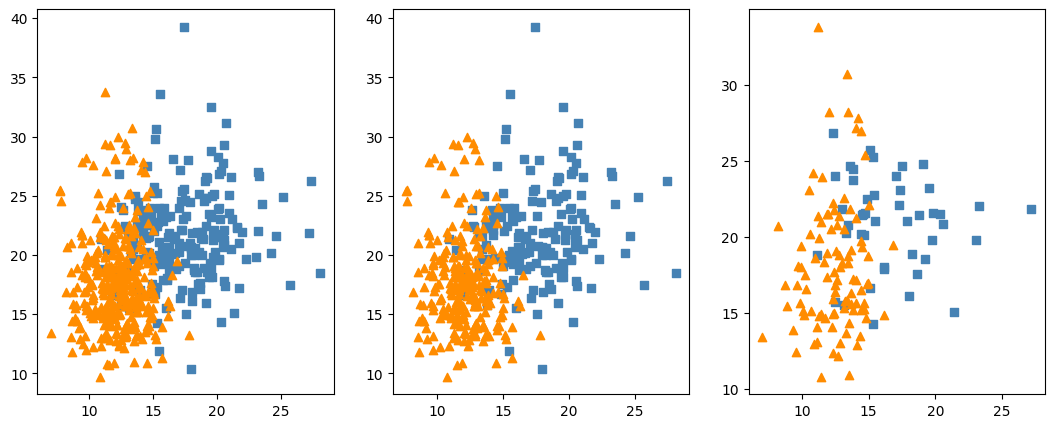

In [57]:
X = dataset.iloc[:,1:3]
y = dataset.iloc[:,0]

#Separando o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y)

fig, ax = plt.subplots(1,3, figsize=(13,5))

plot_dataset(X, y, ax=ax[0])
plot_dataset(X_train, y_train, ax=ax[1])
plot_dataset(X_test, y_test, ax=ax[2])
plt.show()

## Treinamento do modelo

A margem é a característica mais importante do SVM, ao invés de criar apenas uma linha separando duas classes, podemos usar uma margem. A margem é a distâncie entre a reta de classificação e as instâncias mais próximas de cada classe. Utilizando uma instância de cada classe como vetor de suporte, o algoritmo maximiza a margem entre esses dois vetores.

Vamos utilizar uma das implementações do SVM no _sklearn_, o [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

Alguns prânmetros do modelo: 

**C**: default = $1.0$. Penalização por instância errada (_C_), quanto maior a penalização, menos instâncias devem estar presentes dentro da margem e menor deverá ser a distância entre os vetores de suporte.

**kernel**: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’. 

Cada kernel possui um conjunto de hiperparâmetros específicos:

- _linear_ $: \langle x, x'\rangle $
- _poly_ (polinomial) $(\gamma \langle x, x' \rangle + r)^d$: parametros _gamma_ ($\gamma$), _degree_ ($d$), _coef0_ ($r$)
- _rbf_ (Radial Basis Function) $exp(-\gamma ||x-x'||^2)$: parametros _gamma_ ($\gamma$) 
- _sigmoid_ (sigmóide) $tanh(\gamma \langle x, x' \rangle + r)$: parametros _gamma_ ($\gamma$), _coef0_ ($r$) 

Para mais insformações [link](https://scikit-learn.org/stable/modules/svm.html#svm-kernels).

Vamos considerar por hora o kernel linear.



              precision    recall  f1-score   support

           0       0.76      0.71      0.74        45
           1       0.87      0.90      0.88        98

    accuracy                           0.84       143
   macro avg       0.82      0.80      0.81       143
weighted avg       0.84      0.84      0.84       143



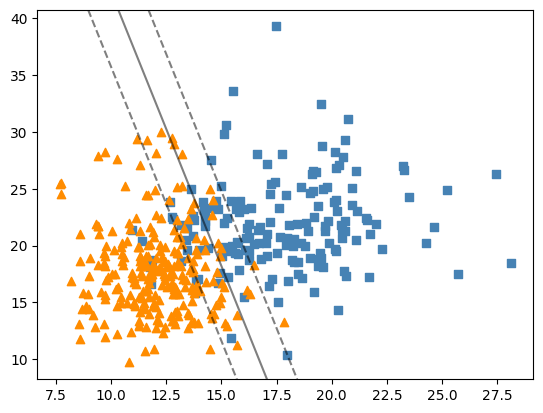

In [58]:
model = SVC(kernel="linear")
model.fit(X_train, y_train)

plot_dataset(X_train, y_train)
plot_svc_decision_function(model)

print(classification_report(y_test, model.predict(X_test)))

## Ajustando alguns parâmetros 

In [59]:
model = SVC()

parameters = {
    'C': [1, 100, 1000, 10000],
    'kernel': ['linear', 'rbf']
}

grid = GridSearchCV(estimator=model,
    param_grid=parameters,
    scoring='accuracy',
    cv=5,
    return_train_score=True)
        
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

# Exibindo a acurácia de cada combinação
results = pd.DataFrame(grid.cv_results_)
print("Acurácia de cada combinação de parâmetros:")
print(results[['params', 'mean_test_score', 'std_test_score']])

# Exibindo o melhor parâmetro
print("\nMelhor parâmetro:", grid.best_params_)
print("Melhor acurácia:", grid.best_score_)

Acurácia de cada combinação de parâmetros:
                             params  mean_test_score  std_test_score
0      {'C': 1, 'kernel': 'linear'}         0.913187        0.011615
1         {'C': 1, 'kernel': 'rbf'}         0.910834        0.021639
2    {'C': 100, 'kernel': 'linear'}         0.915540        0.013343
3       {'C': 100, 'kernel': 'rbf'}         0.908482        0.017095
4   {'C': 1000, 'kernel': 'linear'}         0.910834        0.008984
5      {'C': 1000, 'kernel': 'rbf'}         0.903830        0.024732
6  {'C': 10000, 'kernel': 'linear'}         0.910862        0.015476
7     {'C': 10000, 'kernel': 'rbf'}         0.889767        0.030737

Melhor parâmetro: {'C': 100, 'kernel': 'linear'}
Melhor acurácia: 0.9155403556771547


**Vamos visualizar como esses parâmetros se comportam**


A medida em que a penalização aumenta, os vetores de suporte serão as instâncias mais próximos da fronteira.

C =  1


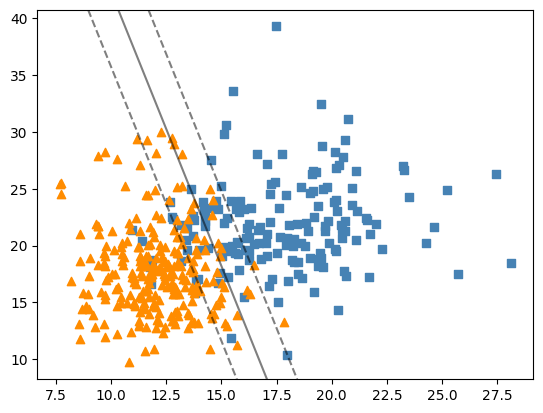

C =  100


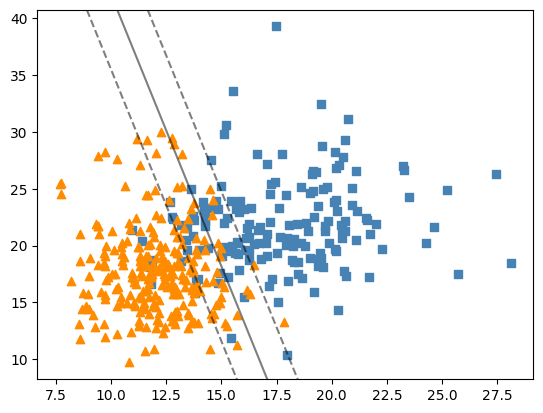

C =  1000


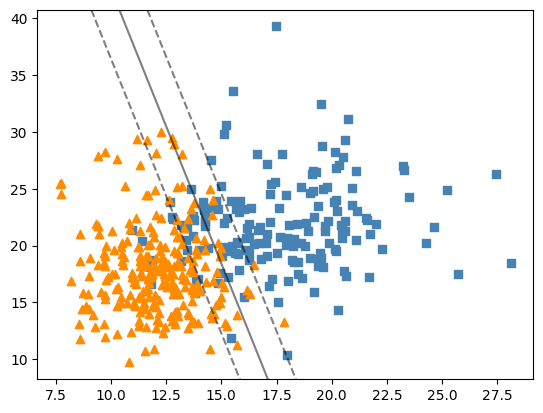

C =  10000


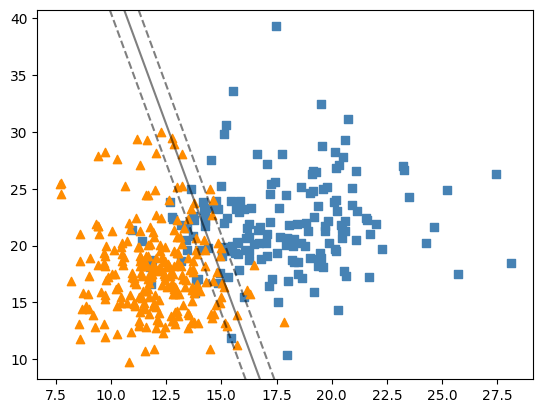

In [60]:
for C in [1, 100, 1000, 10000]:
    plt.figure()
    print("C = ", C)
    model = SVC(C=C, kernel="linear")
    model.fit(X_train, y_train)

    plot_dataset(X_train, y_train)
    plot_svc_decision_function(model)
    plt.show()

C =  1


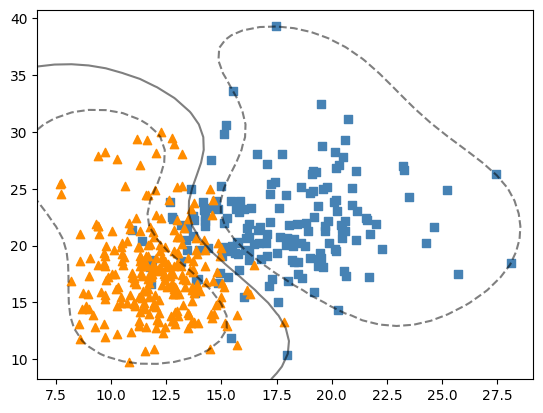

C =  100


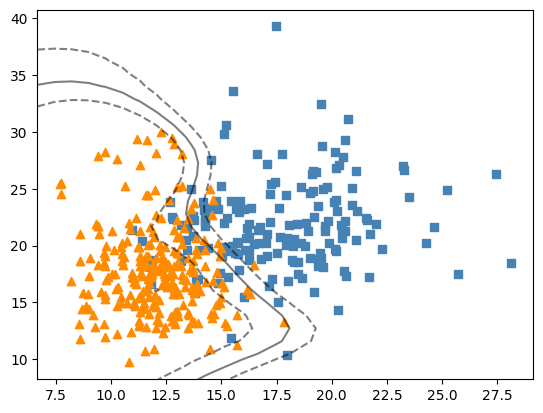

C =  1000


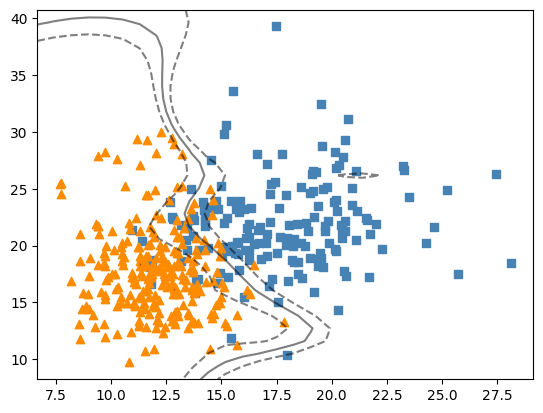

C =  10000


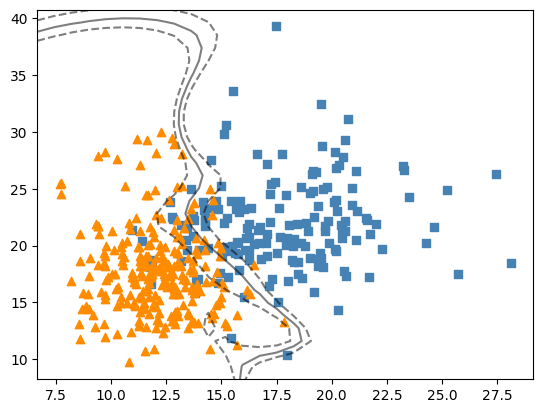

In [61]:
for C in [1, 100, 1000, 10000]:
    plt.figure()
    print("C = ", C)
    model = SVC(C=C, kernel="rbf")
    model.fit(X_train, y_train)

    plot_dataset(X_train, y_train)
    plot_svc_decision_function(model)
    plt.show()

## Avaliando outros datasets

Agora, vamos observar como o SVM se comporta outro dataset.

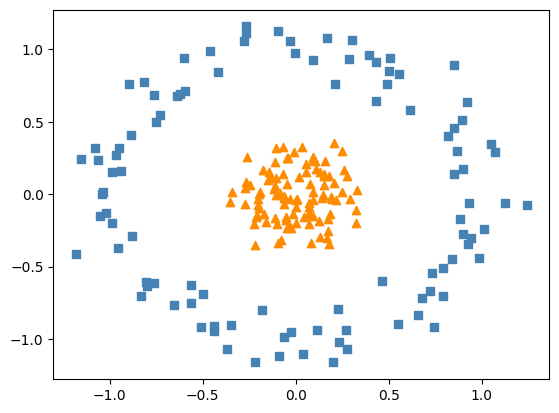

In [62]:
from sklearn.datasets import make_circles

# criação do dataset
X, y = make_circles(n_samples=200, noise=0.1, random_state=199, factor=0.2)

plot_dataset(X, y)

In [63]:
#Separando o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Como o SVM com kernel linear se comporta nesse problema?

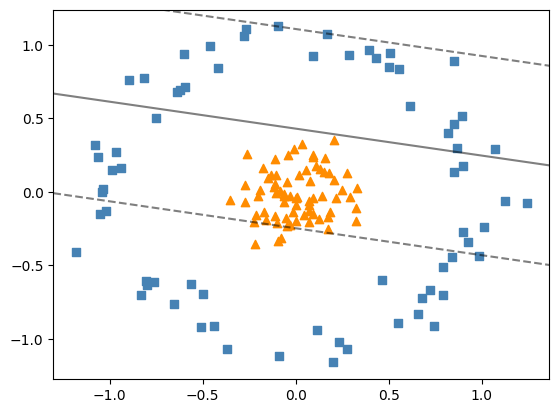

In [64]:
model = SVC(C=10, kernel="linear")
model.fit(X_train, y_train)

plot_dataset(X_train, y_train)
plot_svc_decision_function(model)

Visualizando a região de decisão

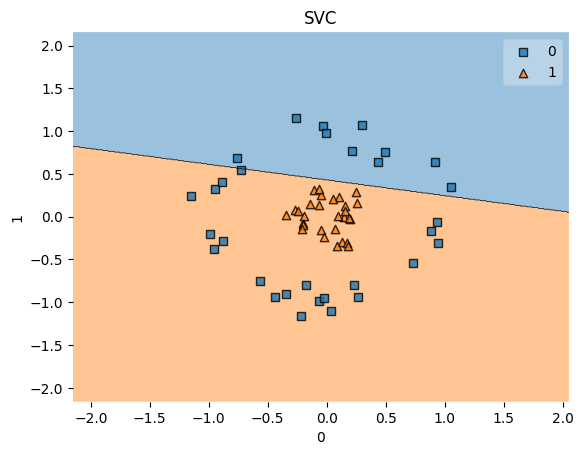

In [65]:
show_decision_region(X_test,y_test, model)

Como podemos observar, a região do problema não é linearmente separável. O SVM tenta criar uma nova dimensão e tenta transformar o problema em um problema linearmente separável com essa nova dimensão. Assim, cada problema requer uma análise sobre qual _kernel_ deve ser utilizado.

Para esse problema, vamos usar o _kernel_ _rbf_ como transformação para os dados.

Assim, vamos criar um classificador SVM que utiliza esse kernel e observar a região de decisão no espaço original.

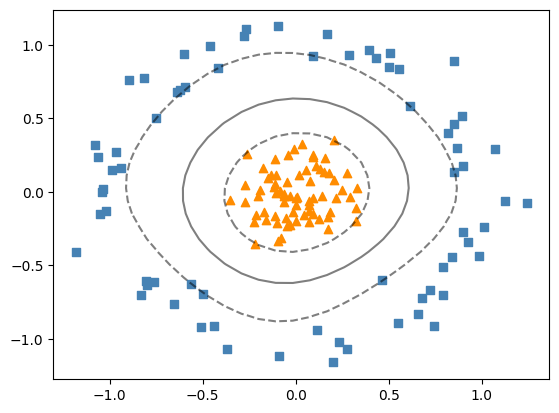

In [66]:
model = SVC(C=10, kernel="rbf")
model.fit(X_train, y_train)

plot_dataset(X_train, y_train)

plot_svc_decision_function(model)

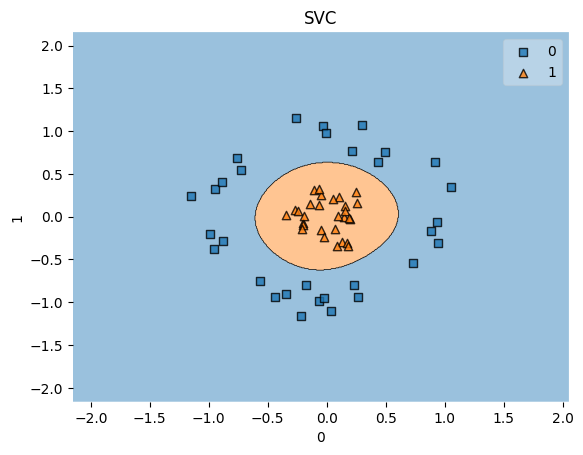

In [67]:
show_decision_region(X_test,y_test,model)